In [1]:
import gymnasium as gym
import numpy as np
import matplotlib.pyplot as plt
import numpy as np

In [2]:
from IPython.display import HTML
HTML("<style>div.output_area pre { font-family: 'Courier New', monospace; }</style>")

Coordinate system: Top left is 0,0. Zeroeth row, second column would be 0,2.

In [3]:
PIECES = {
    'K': [(0,0), (1,0), (2,0), (3,0), (2,1)],   # __|_ knee
    'A': [(0,0), (1,0), (1,1), (2,1), (3,1)],   # __|- Asp
    'C': [(0,0), (0,1), (1,0), (2,0), (2,1)],   # C
    'L': [(0,0), (1,0), (2,0), (2,1), (2,2)],   # |__  L
    'R': [(0,0), (0,1), (1,0), (1,1), (2,0), (2,1)],   # [] rectangle
    'P': [(0,0), (0,1), (1,0), (1,1), (2,0)],   # P
    'I': [(0,0), (0,1), (1,0), (2,0), (3,0)],   # |_ I
    'Z': [(0,0), (0,1), (1,1), (2,1), (2,2)],   # Z
}

In [4]:
class APADEnv(gym.Env):
    def __init__(self):
       super().__init__()
       
       # 7x7 grid with 6 invalid spaces (43 valid total)
       self.grid_size = 7
       self.valid_spaces = 43
       
       # Invalid grid positions
       self.invalid_positions = {(0,6), (1,6), (6,3), (6,4), (6,5), (6,6)}
       
       # 8 pieces: 5 pentominos + 2 sextominos
       # 8 pieces × 2 chirality × 4 rotations × 43 positions
       self.action_space = gym.spaces.Discrete(8 * 2 * 4 * 43)
       
       # Observation: 7x7 grid + 8 remaining pieces
       self.observation_space = gym.spaces.Box(
           low=-1, high=8,  # -1=invalid, 0=empty, 1-8=piece_ids
           shape=(7,8),
           dtype=np.int8
       )
       
       # Initialize grid with invalid positions marked
       self.grid = np.zeros((self.grid_size, self.grid_size), dtype=np.int8)
       for pos in self.invalid_positions:
           self.grid[pos] = -1
       
       self.remaining_pieces = np.ones(8, dtype=bool)
    
    def _get_obs(self):
        return np.concatenate([self.grid.flatten(), self.remaining_pieces.astype(np.int8)])
    
    def reset(self, seed=None, options=None):
        super().reset(seed=seed)
        self.grid = np.zeros((self.grid_size, self.grid_size), dtype=np.int8)
        for pos in self.invalid_positions:
            self.grid[pos] = -1
        self.remaining_pieces = np.ones(8, dtype=bool)
        return self._get_obs(), {}
    
    def _get_piece_coords(self, piece_id, chirality, rotation):
       # Get base piece coordinates
       piece_names = ['K', 'L', 'A', 'C', 'P', 'Z', 'I', 'R']
       base_coords = PIECES[piece_names[piece_id]]
       
       coords = base_coords.copy()
       
       # Apply chirality (flip x-coordinates)
       if chirality == 1:
           coords = [(-x, y) for x, y in coords]
       
       # Apply rotation (0, 90, 180, 270 degrees)
       for _ in range(rotation):
           coords = [(-y, x) for x, y in coords]
       
       # Normalize to ensure anchor at (0,0)
       min_x = min(x for x, y in coords)
       min_y = min(y for x, y in coords)
       coords = [(x - min_x, y - min_y) for x, y in coords]
       
       return coords
    
    def _is_valid_placement(self, piece_id, chirality, rotation, position):
       # Get piece coordinates for this orientation
       coords = self._get_piece_coords(piece_id, chirality, rotation)
       
       # Convert position to grid coordinates
       row, col = divmod(position, self.grid_size)
       
       # Check each piece cell
       for dr, dc in coords:
           r, c = row + dr, col + dc
           
           # Out of bounds
           if r < 0 or r >= self.grid_size or c < 0 or c >= self.grid_size:
               return False
           
           # Invalid position or already occupied
           if self.grid[r, c] != 0:
               return False
       
       return True
    
    def _place_piece(self, piece_id, chirality, rotation, position):
       coords = self._get_piece_coords(piece_id, chirality, rotation)
       row, col = divmod(position, self.grid_size)
       
       for dr, dc in coords:
           self.grid[row + dr, col + dc] = piece_id + 1
       
       self.remaining_pieces[piece_id] = False

    # The action passed will be an integer 0 - 2751, spanning the action space.
    # This covers all the possible actions: piece ID (8) x chirality (2) x rotation (4)  x position (43) = 2752
    def step(self, action):
        # Decode action
        piece_id = action // (2 * 4 * 43)
        remaining = action % (2 * 4 * 43)
        chirality = remaining // (4 * 43)
        remaining = remaining % (4 * 43)
        rotation = remaining // 43
        position = remaining % 43
        
        # Check piece available
        if not self.remaining_pieces[piece_id]:
           return self._get_obs(), -10, False, False, {}
        
        # Check valid placement
        if not self._is_valid_placement(piece_id, chirality, rotation, position):
           return self._get_obs(), -1, False, False, {}
        
        # Place piece
        self._place_piece(piece_id, chirality, rotation, position)
        
        # Calculate reward and done
        reward = 10
        done = np.sum(self.remaining_pieces) == 0
        if done:
            reward += 100  # Big bonus for solving
        
        return self._get_obs(), reward, done, False, {}

    def visualize(self):
       fig, ax = plt.subplots(figsize=(6,6))
       
       display = np.ones((*self.grid.shape, 3))
       display[self.grid == -1] = [0, 0, 0]
       display[self.grid > 0] = [0.5, 0.5, 0.5]
       
       ax.imshow(display)
       
       # Grid lines
       for i in range(self.grid.shape[0] + 1):
           ax.axhline(i - 0.5, color='gray', linewidth=1)
       for i in range(self.grid.shape[1] + 1):
           ax.axvline(i - 0.5, color='gray', linewidth=1)
       
       # Piece outlines
       for piece_id in range(1, 9):
           mask = self.grid == piece_id
           if not mask.any():
               continue
           
           for r in range(self.grid.shape[0]):
               for c in range(self.grid.shape[1]):
                   if mask[r, c]:
                       if r == 0 or not mask[r-1, c]:
                           ax.axhline(r - 0.5, xmin=c/self.grid.shape[1], xmax=(c+1)/self.grid.shape[1], color='black', linewidth=3)
                       if r == self.grid.shape[0]-1 or not mask[r+1, c]:
                           ax.axhline(r + 0.5, xmin=c/self.grid.shape[1], xmax=(c+1)/self.grid.shape[1], color='black', linewidth=3)
                       if c == 0 or not mask[r, c-1]:
                           ax.axvline(c - 0.5, ymin=(self.grid.shape[0]-r-1)/self.grid.shape[0], ymax=(self.grid.shape[0]-r)/self.grid.shape[0], color='black', linewidth=3)
                       if c == self.grid.shape[1]-1 or not mask[r, c+1]:
                           ax.axvline(c + 0.5, ymin=(self.grid.shape[0]-r-1)/self.grid.shape[0], ymax=(self.grid.shape[0]-r)/self.grid.shape[0], color='black', linewidth=3)
       
       ax.set_xticks([])
       ax.set_yticks([])
       plt.show()
    
    def visualize_ascii(self):
        for row in self.grid:
            print(''.join(['O' if x==0 else 'X' if x==-1 else str(x) for x in row]))

In [5]:
def test_environment():
    env = APADEnv()
    
    # Test 1: Grid initialization
    assert env.grid.shape == (7, 7)
    assert np.sum(env.grid == -1) == 6  # Invalid positions
    assert np.sum(env.remaining_pieces) == 8  # All pieces available
    
    # Test 2: Piece coordinate generation
    coords_k = env._get_piece_coords(0, 0, 0)  # K piece, no flip, no rotation
    expected_k = [(0,0), (1,0), (2,0), (3,0), (2,1)]
    assert coords_k == expected_k
    
    # Test 3: Rotation
    coords_k_rot = env._get_piece_coords(0, 0, 1)  # K piece rotated 90°
    assert len(coords_k_rot) == 5
    
    # Test 4: Valid placement
    valid = env._is_valid_placement(0, 0, 0, 14)  # Position (2,0) on grid
    assert isinstance(valid, bool)
    
    # Test 5: Invalid placement (out of bounds)
    valid = env._is_valid_placement(0, 0, 0, 6)  # Top-right corner invalid
    assert valid == False
    
    # Test 6: Piece placement
    if env._is_valid_placement(0, 0, 0, 14):
       env._place_piece(0, 0, 0, 14)
       assert not env.remaining_pieces[0]  # Piece marked as used
       assert np.sum(env.grid == 1) == 5   # 5 cells occupied by piece
    
    print("All tests passed")
    
test_environment()

All tests passed


In [6]:
def test_overlap_and_reset():
   env = APADEnv()
   
   # Find two valid positions for same piece type
   pos1 = 14  # Should be valid
   pos2 = 15  # Adjacent position
   
   # Place first piece
   if env._is_valid_placement(0, 0, 0, pos1):
       env._place_piece(0, 0, 0, pos1)
       
       # Try to place overlapping piece (should fail)
       overlap_valid = env._is_valid_placement(1, 0, 0, pos2)
       assert overlap_valid == False
       
       # Test reset
       obs, info = env.reset()
       assert np.sum(env.remaining_pieces) == 8  # All pieces available
       assert np.sum(env.grid > 0) == 0  # Only invalid cells marked
       
   print("Overlap and reset tests passed!")

test_overlap_and_reset()

Overlap and reset tests passed!


In [7]:
def test_random_trial():
    env = APADEnv()
    obs, _ = env.reset()
    
    while True:
       # Check if any valid moves exist
       valid_moves = []
       for action in range(env.action_space.n):
           piece_id = action // (2 * 4 * 43)
           if env.remaining_pieces[piece_id]:
               remaining = action % (2 * 4 * 43)
               chirality = remaining // (4 * 43)
               remaining = remaining % (4 * 43)
               rotation = remaining // 43
               position = remaining % 43
               if env._is_valid_placement(piece_id, chirality, rotation, position):
                   valid_moves.append(action)
       
       if not valid_moves:
           break
           
       action = np.random.choice(valid_moves)
       obs, reward, done, truncated, _ = env.step(action)
       if done:
           break
    
    #print(f"Pieces remaining: {sum(env.remaining_pieces)}")
    return env

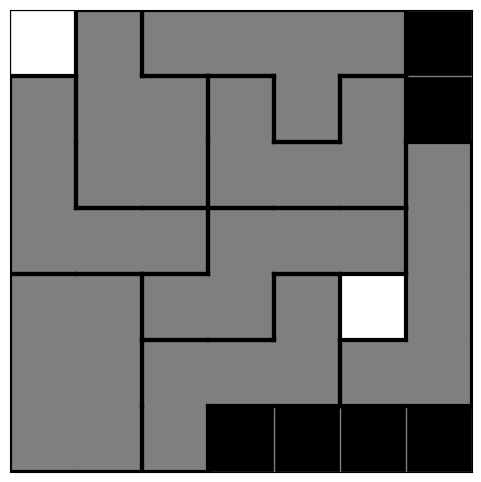

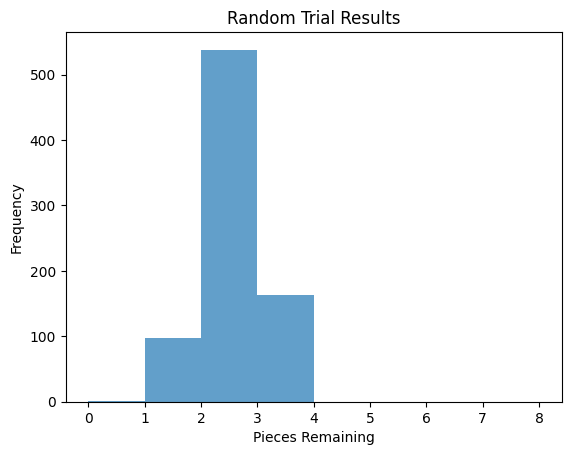

Trials: 799, Success rate: 0.13%


<Figure size 640x480 with 0 Axes>

In [9]:
i = 0
remaining_pieces = []
while True:
    i += 1
    env = test_random_trial()
    remaining_pieces.append(np.sum(env.remaining_pieces))
    if np.sum(env.remaining_pieces) == 0:
        env.visualize()
        break

plt.hist(remaining_pieces, bins=range(9), alpha=0.7)
plt.xlabel('Pieces Remaining')
plt.ylabel('Frequency')
plt.title('Random Trial Results')
plt.show()
plt.savefig('trial_results.png')

print(f"Trials: {i}, Success rate: {remaining_pieces.count(0)/i:.2%}")